In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [3]:
def f1score(TP,FP,FN):
    if TP==0:
        return 0.0
    precision= TP/(Tp+FP)
    recall = TP/(TP+FN)
    if precision + recall == 0:
      return 0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def matthews_correlation_coefficient(tp, tn, fp, fn):
    """
    Calculate the Matthews Correlation Coefficient (MCC).

    Parameters:
        tp (int): True positives.
        tn (int): True negatives.
        fp (int): False positives.
        fn (int): False negatives.

    Returns:
        float: The MCC value.
    """
    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    if denominator == 0:
        return 0.0

    return numerator / denominator

def accuracy(tp, tn, fp, fn):
    """
    Calculate accuracy.

    Parameters:
        tp (int): True positives.
        tn (int): True negatives.
        fp (int): False positives.
        fn (int): False negatives.

    Returns:
        float: The accuracy.
    """
    total = tp + tn + fp + fn
    if total == 0:
        return 0.0
    return (tp + tn) / total
from sklearn.metrics import roc_auc_score

def auc_score(true_labels, predicted_probabilities):
    """
    Calculate the Area Under the Curve (AUC) score.

    Parameters:
        true_labels (list or array): Ground truth binary labels (0 or 1).
        predicted_probabilities (list or array): Predicted probabilities for the positive class.

    Returns:
        float: The AUC score.
    """
    return roc_auc_score(true_labels, predicted_probabilities)


In [4]:
import pandas as pd
data =pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


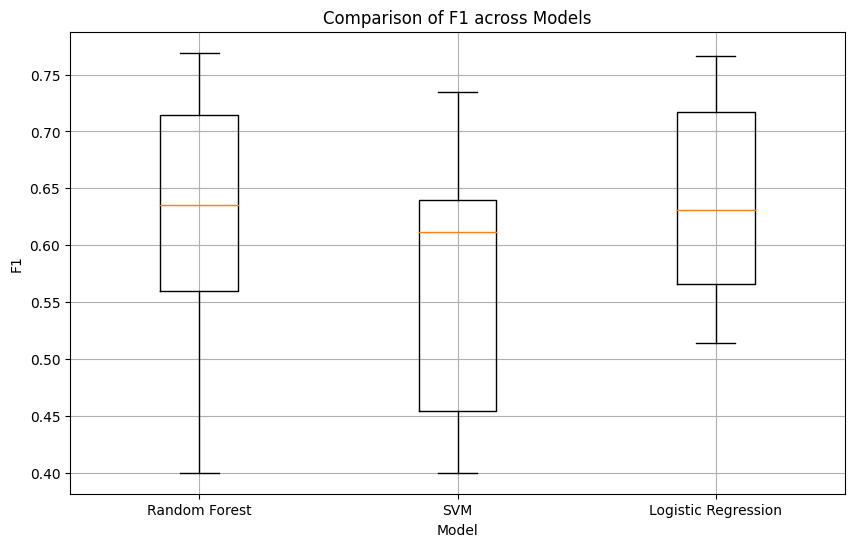

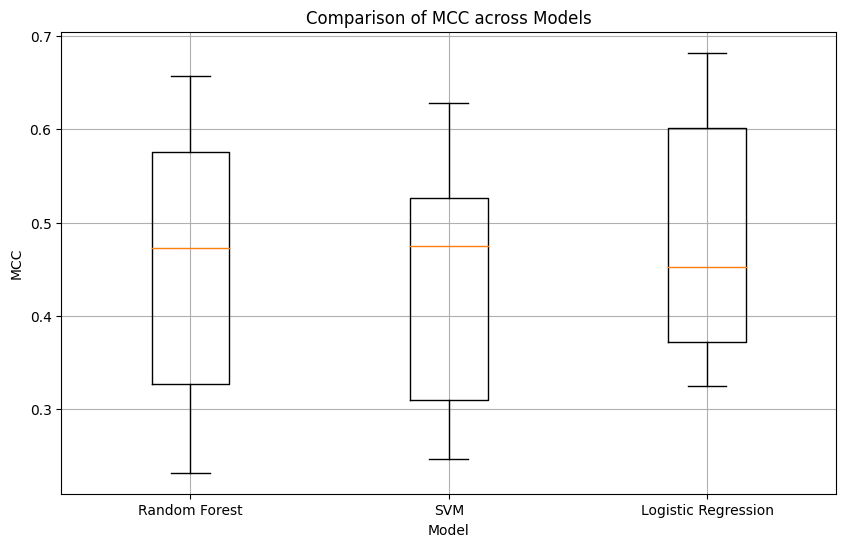

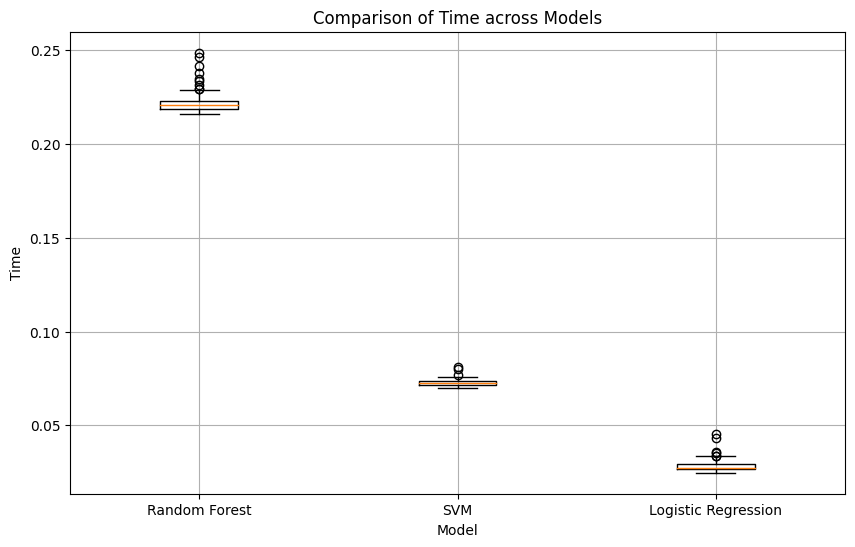

In [5]:

# Load dataset
# Replace this with your actual dataset loading method if needed
data = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')  # Assuming your dataset is in a CSV file
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}
# Metrics initialization
metrics = ["Accuracy", "F1", "MCC", "AUC", "Time"]
results = {model: {metric: [] for metric in metrics} for model in models}

# 10-fold CV repeated 10 times
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for repeat in range(10):  # Outer loop for 10 repetitions
    for train_index, test_index in kf.split(X):  # Inner loop for 10 folds
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        for model_name, model in models.items():
            start_time = time.time()  # Start timing
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]  # Probability for AUC
            end_time = time.time()  # End timing

            # Compute metrics
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob)
            elapsed_time = end_time - start_time

            # Store results
            results[model_name]["Accuracy"].append(acc)
            results[model_name]["F1"].append(f1)
            results[model_name]["MCC"].append(mcc)
            results[model_name]["AUC"].append(auc)
            results[model_name]["Time"].append(elapsed_time)

# Convert results to DataFrames for analysis
final_results = {
    model: pd.DataFrame(data=metrics_dict)
    for model, metrics_dict in results.items()
}

# Generate Boxplots
for metric in ["F1", "MCC", "Time"]:
    plt.figure(figsize=(10, 6))
    data_to_plot = [final_results[model][metric] for model in models.keys()]
    plt.boxplot(data_to_plot, labels=models.keys())
    plt.title(f'Comparison of {metric} across Models')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.grid(True)
    plt.show()

# Optionally, save the results to a CSV
for model, df in final_results.items():
    df.to_csv(f"{model}_results.csv", index=False)



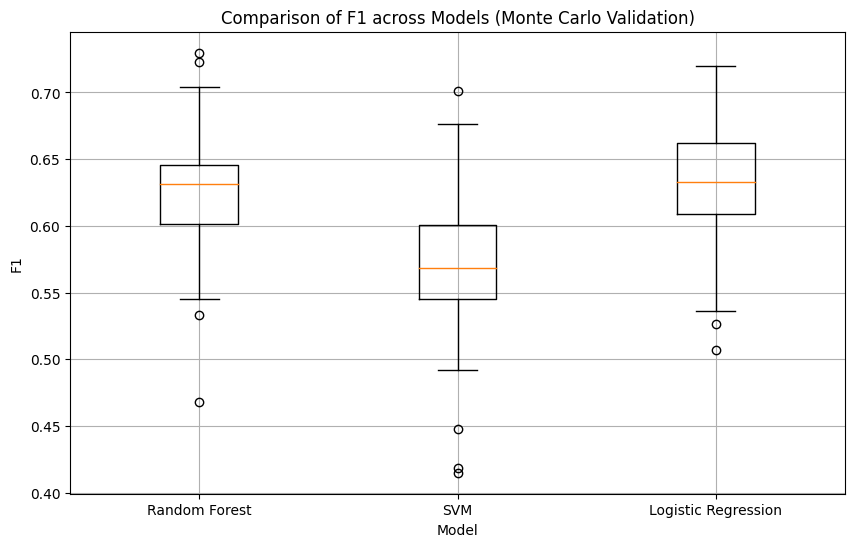

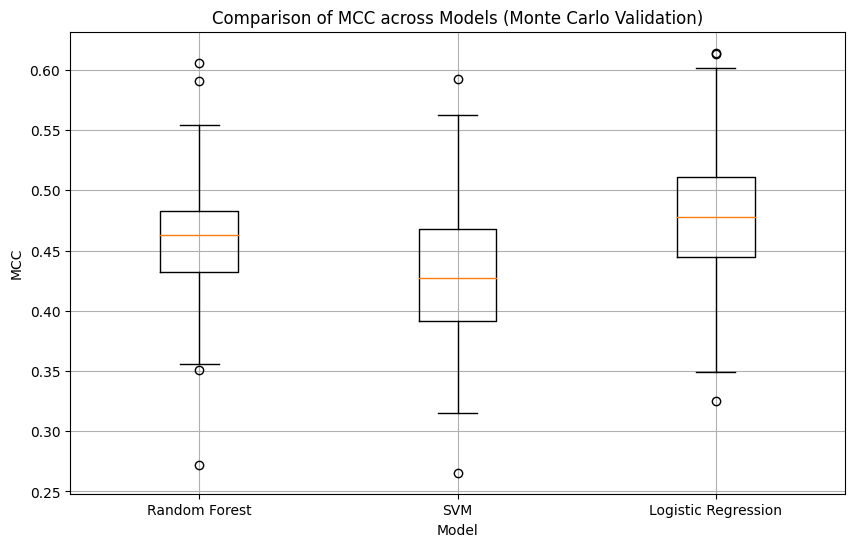

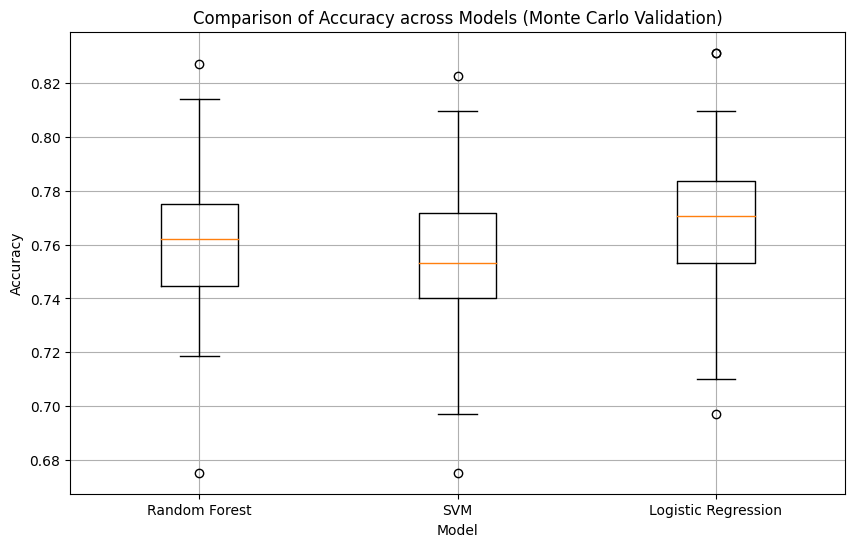

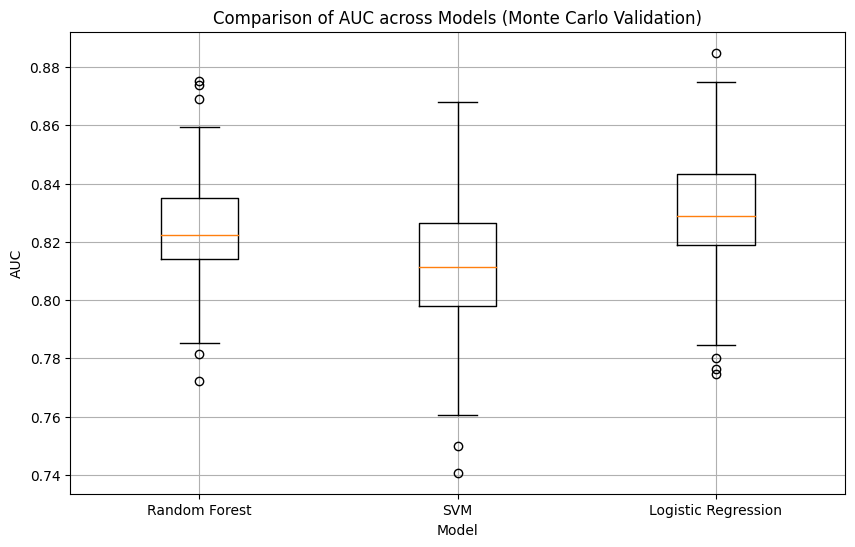

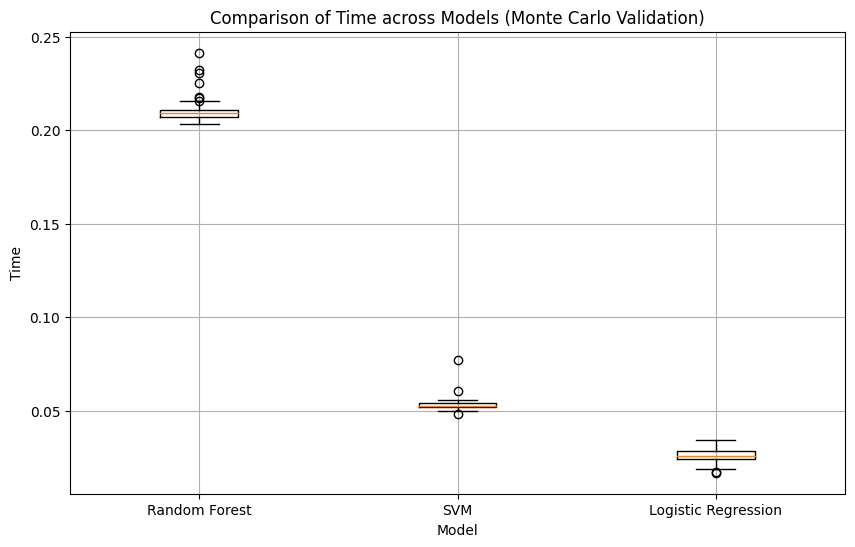

In [6]:
from sklearn.model_selection import train_test_split
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

# Metrics initialization
metrics = ["Accuracy", "F1", "MCC", "AUC", "Time"]
results = {model: {metric: [] for metric in metrics} for model in models}

# Monte Carlo Cross Validation (100 iterations)
n_iterations = 100
for iteration in range(n_iterations):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=iteration)
    
    for model_name, model in models.items():
        start_time = time.time()  # Start timing
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Probability for AUC
        end_time = time.time()  # End timing

        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        elapsed_time = end_time - start_time

        # Store results
        results[model_name]["Accuracy"].append(acc)
        results[model_name]["F1"].append(f1)
        results[model_name]["MCC"].append(mcc)
        results[model_name]["AUC"].append(auc)
        results[model_name]["Time"].append(elapsed_time)

# Convert results to DataFrames for analysis
final_results = {
    model: pd.DataFrame(data=metrics_dict)
    for model, metrics_dict in results.items()
}

# Generate Boxplots
for metric in ["F1", "MCC", "Accuracy", "AUC", "Time"]:
    plt.figure(figsize=(10, 6))
    data_to_plot = [final_results[model][metric] for model in models.keys()]
    plt.boxplot(data_to_plot, labels=models.keys())
    plt.title(f'Comparison of {metric} across Models (Monte Carlo Validation)')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.grid(True)
    plt.show()

# Optionally, save the results to a CSV
for model, df in final_results.items():
    df.to_csv(f"{model}_results_monte_carlo.csv", index=False)


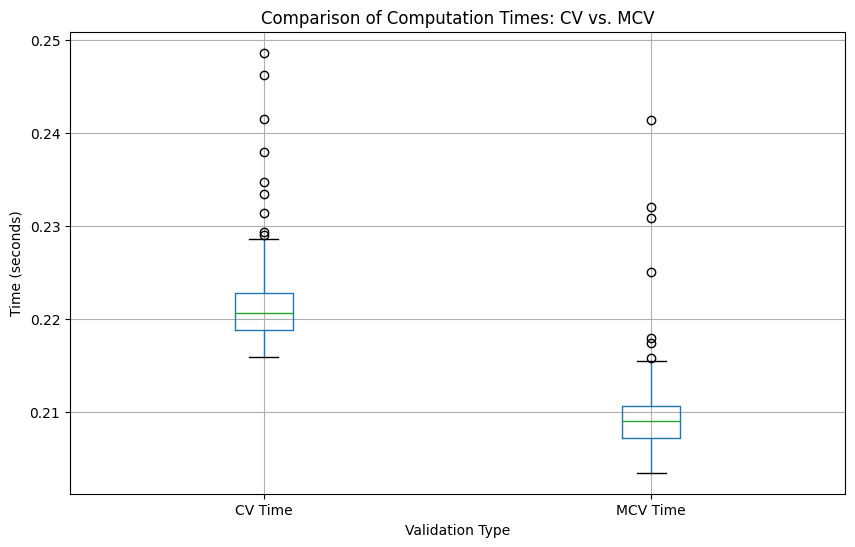

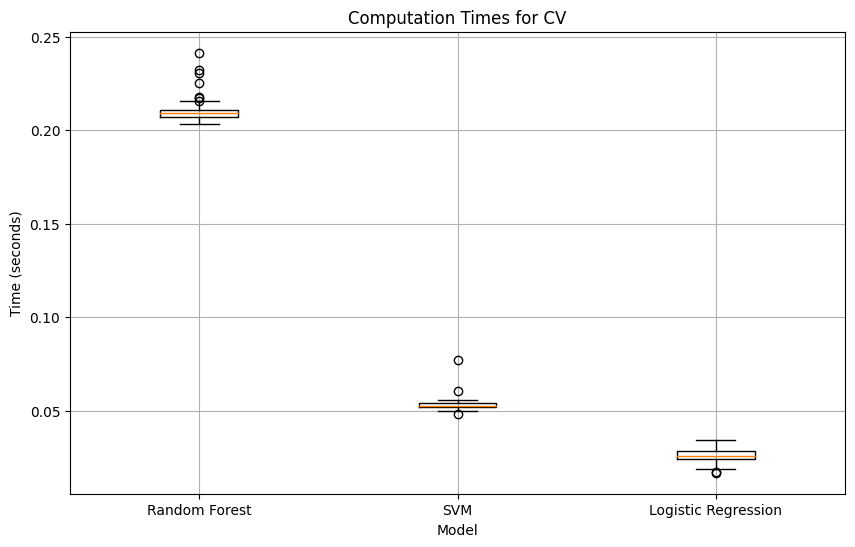

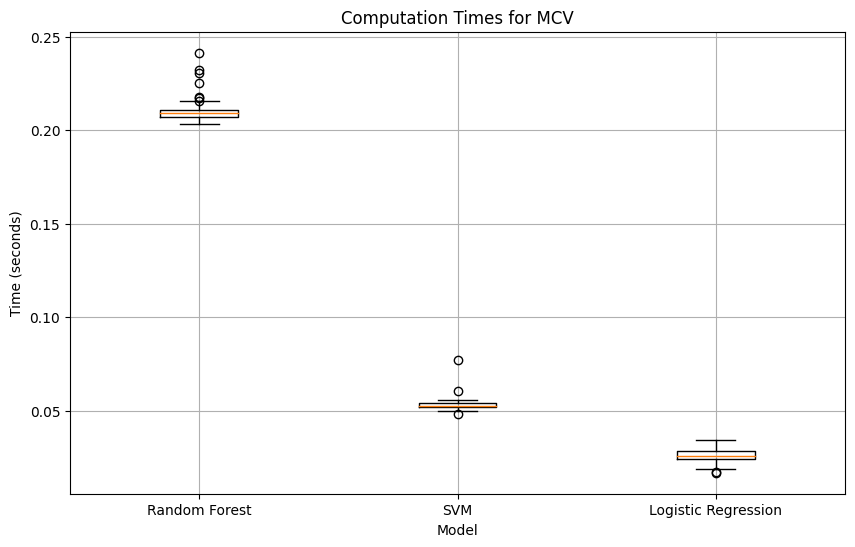

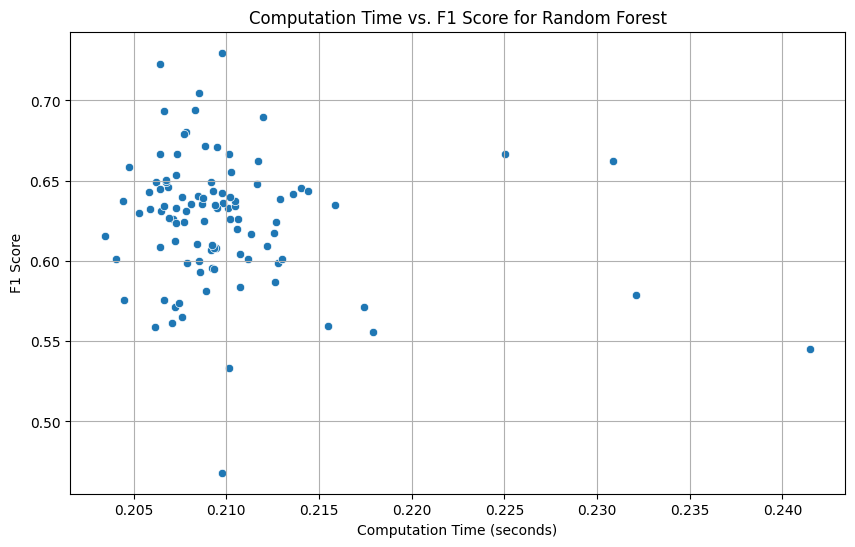

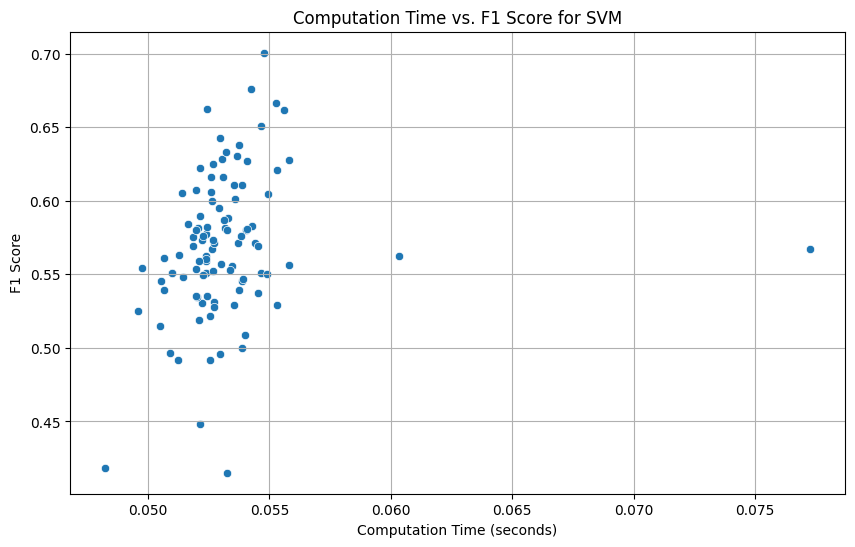

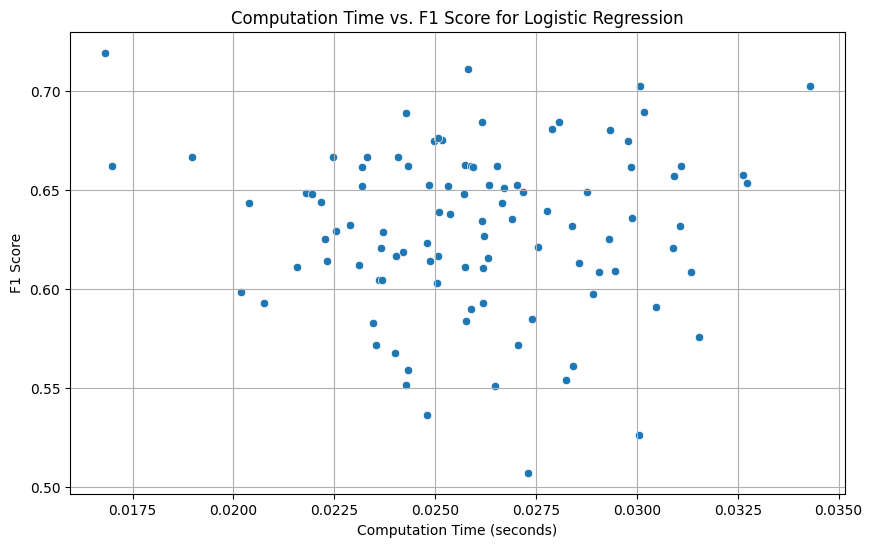

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load computation times for CV and MCV
cv_time = pd.read_csv("/kaggle/working/Random Forest_results.csv")["Time"]  # Example: adjust file names
mcv_time = pd.read_csv("/kaggle/working/Random Forest_results_monte_carlo.csv")["Time"]  # Example: adjust file names

# Combine CV and MCV data for plotting
comparison_df = pd.DataFrame({
    "CV Time": cv_time,
    "MCV Time": mcv_time
})
plt.figure(figsize=(10, 6))
comparison_df.boxplot()
plt.title("Comparison of Computation Times: CV vs. MCV")
plt.ylabel("Time (seconds)")
plt.xlabel("Validation Type")
plt.grid(True)
plt.show()
# Assuming you have results for all models (Random Forest, SVM, Logistic Regression)
cv_times = {
    "Random Forest": final_results["Random Forest"]["Time"],
    "SVM": final_results["SVM"]["Time"],
    "Logistic Regression": final_results["Logistic Regression"]["Time"]
}

mcv_times = {
    "Random Forest": final_results["Random Forest"]["Time"],
    "SVM": final_results["SVM"]["Time"],
    "Logistic Regression": final_results["Logistic Regression"]["Time"]
}

# Generate separate boxplots for CV and MCV
for method, times in [("CV", cv_times), ("MCV", mcv_times)]:
    plt.figure(figsize=(10, 6))
    data_to_plot = [times[model] for model in cv_times.keys()]
    plt.boxplot(data_to_plot, labels=cv_times.keys())
    plt.title(f"Computation Times for {method}")
    plt.ylabel("Time (seconds)")
    plt.xlabel("Model")
    plt.grid(True)
    plt.show()
import seaborn as sns

# Scatter plot for time vs. F1 score (example)
for model in models.keys():
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=final_results[model]["Time"], y=final_results[model]["F1"])
    plt.title(f"Computation Time vs. F1 Score for {model}")
    plt.xlabel("Computation Time (seconds)")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()


Best Logistic Regression Parameters: {'C': 1}
Best KNN Parameters: {'n_neighbors': 7}


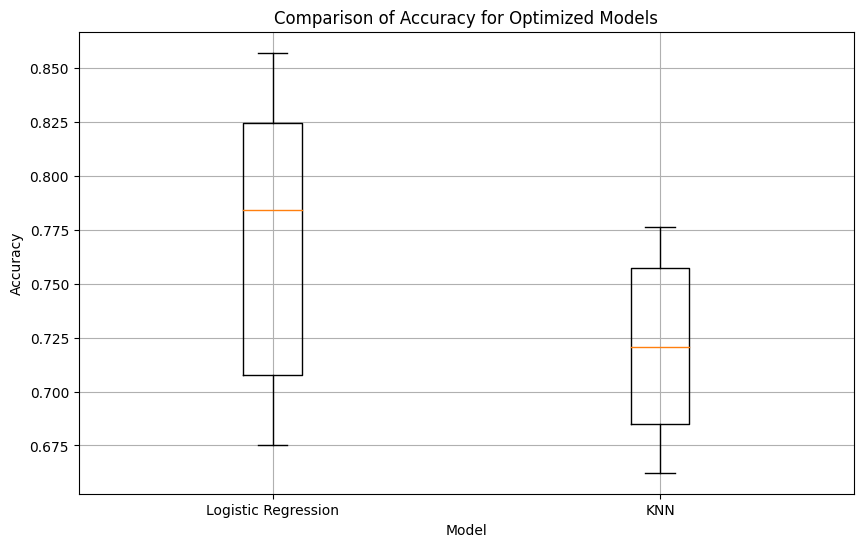

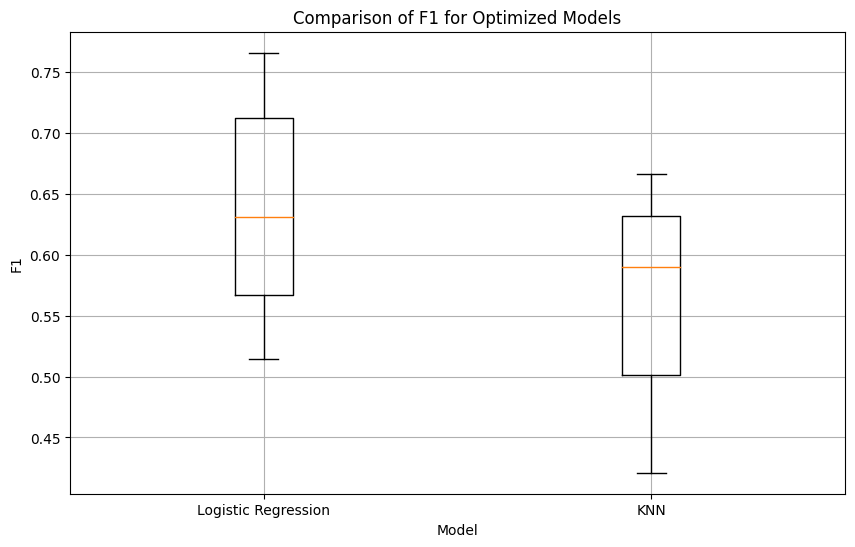

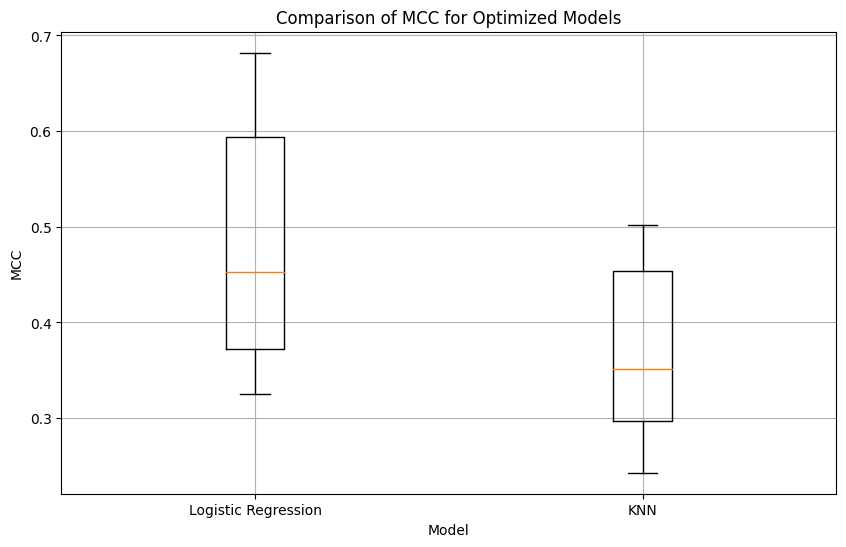

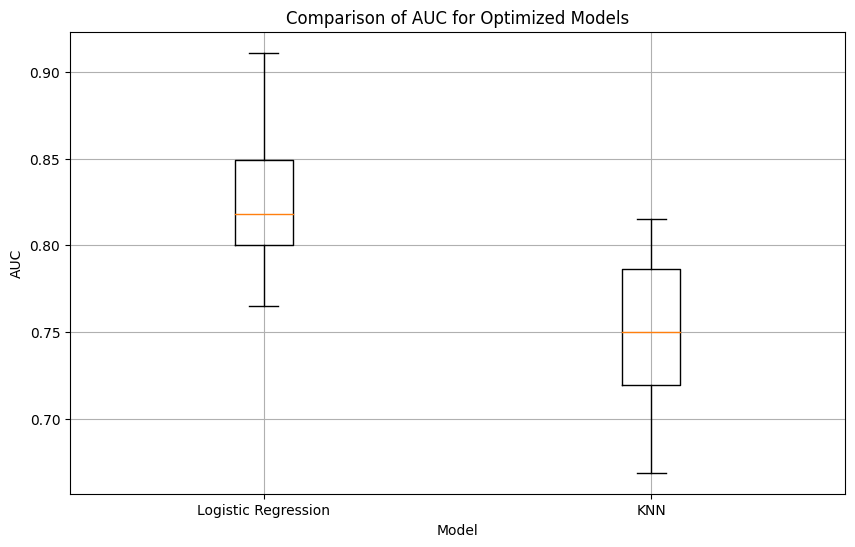

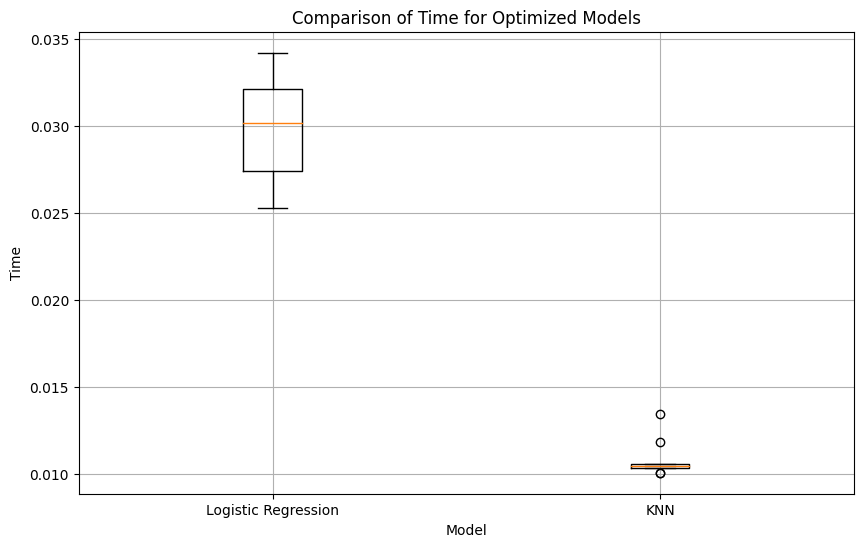

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grids
logreg_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
knn_param_grid = {"n_neighbors": [3, 5, 7, 9, 11]}

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier()

# Perform Grid Search with 10-fold CV for Logistic Regression
logreg_grid_search = GridSearchCV(estimator=logreg, param_grid=logreg_param_grid, cv=10, scoring="accuracy")
logreg_grid_search.fit(X, y)
best_logreg_params = logreg_grid_search.best_params_
print(f"Best Logistic Regression Parameters: {best_logreg_params}")

# Perform Grid Search with 10-fold CV for KNN
knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=10, scoring="accuracy")
knn_grid_search.fit(X, y)
best_knn_params = knn_grid_search.best_params_
print(f"Best KNN Parameters: {best_knn_params}")


# Initialize models with tuned hyperparameters
logreg_tuned = LogisticRegression(C=best_logreg_params["C"], max_iter=1000, random_state=42)
knn_tuned = KNeighborsClassifier(n_neighbors=best_knn_params["n_neighbors"])

# Metrics initialization
metrics = ["Accuracy", "F1", "MCC", "AUC", "Time"]
results_tuned = {
    "Logistic Regression": {metric: [] for metric in metrics},
    "KNN": {metric: [] for metric in metrics}
}

# 10-Fold CV
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for model_name, model in [("Logistic Regression", logreg_tuned), ("KNN", knn_tuned)]:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        end_time = time.time()

        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
        elapsed_time = end_time - start_time

        # Store results
        results_tuned[model_name]["Accuracy"].append(acc)
        results_tuned[model_name]["F1"].append(f1)
        results_tuned[model_name]["MCC"].append(mcc)
        results_tuned[model_name]["AUC"].append(auc)
        results_tuned[model_name]["Time"].append(elapsed_time)

# Convert results to DataFrames for analysis
final_results_tuned = {
    model: pd.DataFrame(data=metrics_dict)
    for model, metrics_dict in results_tuned.items()
}


# Generate Boxplots for Metrics
for metric in ["Accuracy", "F1", "MCC", "AUC", "Time"]:
    plt.figure(figsize=(10, 6))
    data_to_plot = [final_results_tuned[model][metric].dropna() for model in results_tuned.keys()]
    plt.boxplot(data_to_plot, labels=results_tuned.keys())
    plt.title(f'Comparison of {metric} for Optimized Models')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.grid(True)
    plt.show()


Best Logistic Regression Parameters: {'C': 1}
Best KNN Parameters: {'n_neighbors': 7}


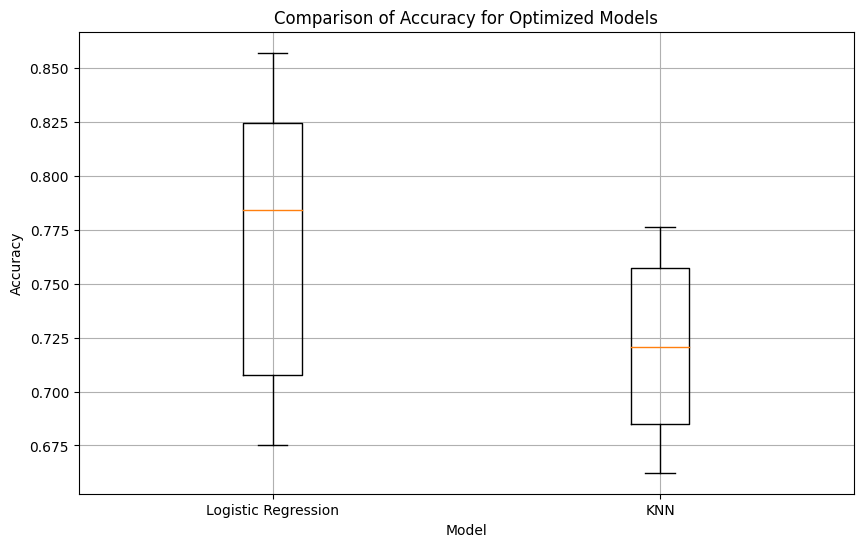

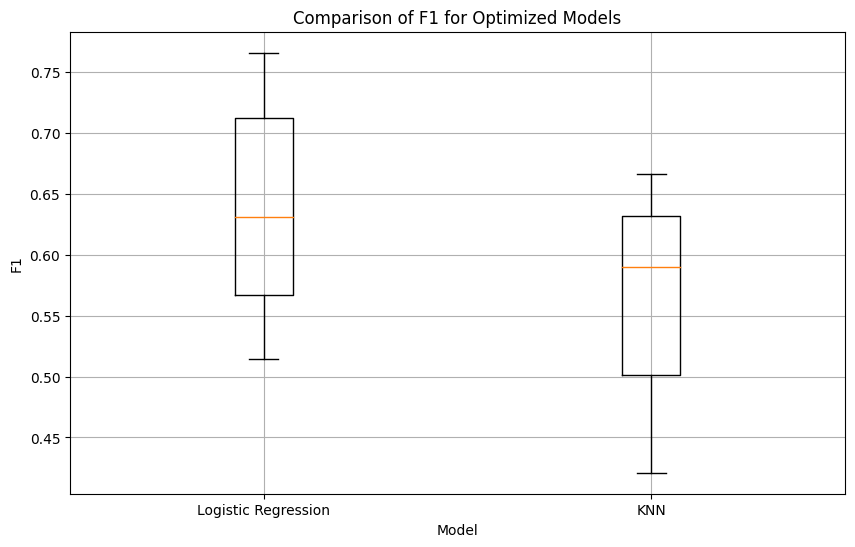

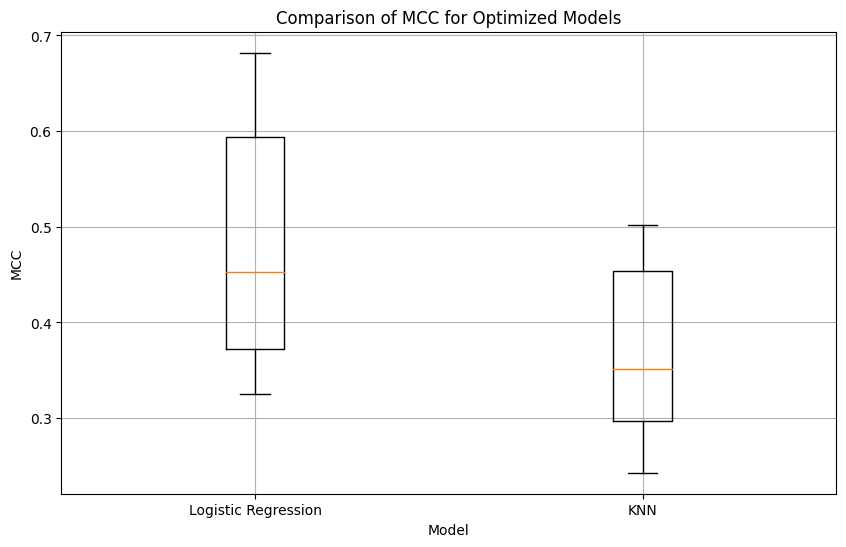

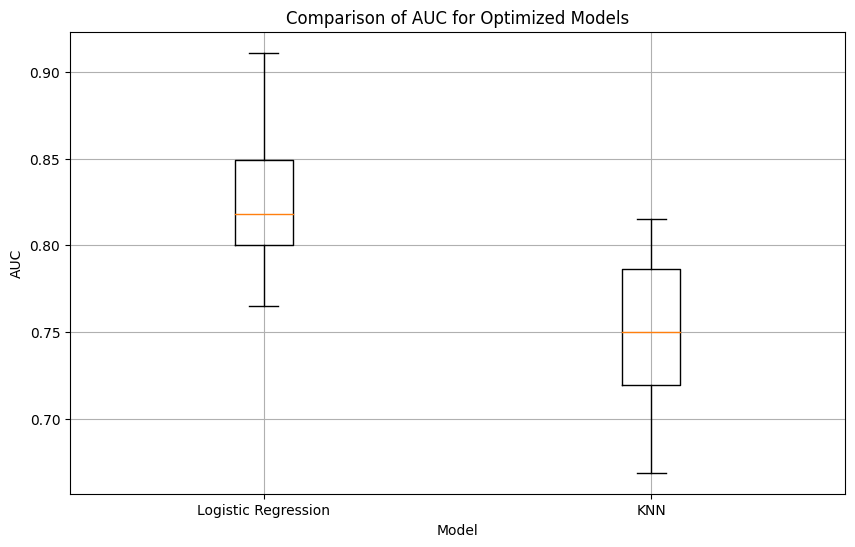

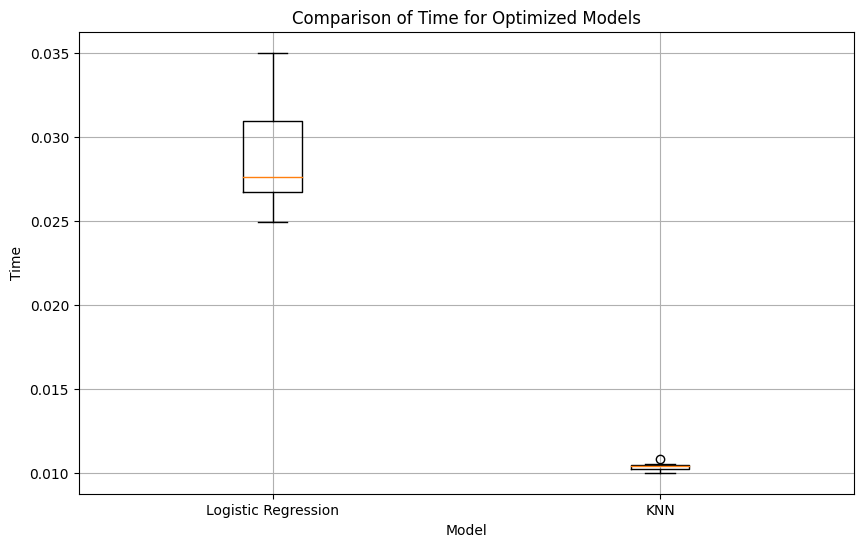

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grids
logreg_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
knn_param_grid = {"n_neighbors": [3, 5, 7, 9, 11]}

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
knn = KNeighborsClassifier()

# Perform Grid Search with 10-fold CV for Logistic Regression
logreg_grid_search = GridSearchCV(estimator=logreg, param_grid=logreg_param_grid, cv=10, scoring="accuracy")
logreg_grid_search.fit(X, y)
best_logreg_params = logreg_grid_search.best_params_
print(f"Best Logistic Regression Parameters: {best_logreg_params}")

# Perform Grid Search with 10-fold CV for KNN
knn_grid_search = GridSearchCV(estimator=knn, param_grid=knn_param_grid, cv=10, scoring="accuracy")
knn_grid_search.fit(X, y)
best_knn_params = knn_grid_search.best_params_
print(f"Best KNN Parameters: {best_knn_params}")


# Initialize models with tuned hyperparameters
logreg_regularized = LogisticRegression(C=1, penalty="l2", max_iter=1000, random_state=42)
knn_regularized = KNeighborsClassifier(n_neighbors=7)

# Metrics initialization
metrics = ["Accuracy", "F1", "MCC", "AUC", "Time"]
results_tuned = {
    "Logistic Regression": {metric: [] for metric in metrics},
    "KNN": {metric: [] for metric in metrics}
}

# 10-Fold CV
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for model_name, model in [("Logistic Regression", logreg_tuned), ("KNN", knn_tuned)]:
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        end_time = time.time()

        # Compute metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
        elapsed_time = end_time - start_time

        # Store results
        results_tuned[model_name]["Accuracy"].append(acc)
        results_tuned[model_name]["F1"].append(f1)
        results_tuned[model_name]["MCC"].append(mcc)
        results_tuned[model_name]["AUC"].append(auc)
        results_tuned[model_name]["Time"].append(elapsed_time)

# Convert results to DataFrames for analysis
final_results_tuned = {
    model: pd.DataFrame(data=metrics_dict)
    for model, metrics_dict in results_tuned.items()
}


# Generate Boxplots for Metrics
for metric in ["Accuracy", "F1", "MCC", "AUC", "Time"]:
    plt.figure(figsize=(10, 6))
    data_to_plot = [final_results_tuned[model][metric].dropna() for model in results_tuned.keys()]
    plt.boxplot(data_to_plot, labels=results_tuned.keys())
    plt.title(f'Comparison of {metric} for Optimized Models')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.grid(True)
    plt.show()
